<a href="https://colab.research.google.com/github/rohitsharma21791/COVID_Directory/blob/main/Covid_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')
!nvidia-smi

In [92]:
############## Reset variables###########
%reset -f

In [ ]:
############## Unrar compressed image dataset
!unrar x -Y "/content/drive/MyDrive/Gray.rar" "/content/"

In [94]:

import numpy as np
import os
import shutil
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.callbacks import EarlyStopping,CSVLogger
from time import time
################## Read the Images and Labels##########################
import tensorflow as tf
from PIL import Image

In [95]:

########## import confusion matrix and calc_precsion_recall python files to current working directory
from distutils.file_util import copy_file
copy_file("/content/drive/MyDrive/Colab Notebooks/make_confusion_matrix.py", "/content/")

copy_file("/content/drive/MyDrive/Colab Notebooks/calc_precision_recall.py", "/content/")


('/content/calc_precision_recall.py', 1)

In [96]:
dir = '/content/Covid_MI'
if os.path.exists(dir):
    shutil.rmtree(dir)
src_dir1='/content/Gray/ECG_covid'
 
dst_dir1 ='/content/Covid_MI'
  
shutil.copytree( src_dir1, dst_dir1)

'/content/Covid_MI'

In [97]:
########## read Image data set##################
image_directory = '/content/Covid_MI/'
SIZE =224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

Covid_images = os.listdir(image_directory + 'ECG Images of COVID-19 Patients (250)/')
for i, image_name in enumerate(Covid_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread((image_directory + 'ECG Images of COVID-19 Patients (250)/' + image_name),0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

MI_images = os.listdir(image_directory + 'ECG Images of Patient that have abnormal heart beats (548)/')
for i, image_name in enumerate(MI_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread((image_directory +  'ECG Images of Patient that have abnormal heart beats (548)/' + image_name),0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

       

dataset = np.array(dataset)
label = np.array(label)


########################## Split train, test and valid ############################
#from keras.utils import to_categorical

X_train1, X_test, y_train1, y_test = train_test_split(dataset,label, test_size = 0.1,random_state = 32,shuffle=True,stratify=label)
X_train, X_val, y_train, y_val=train_test_split(X_train1,y_train1, test_size = 0.1, random_state = 32,shuffle=True,stratify=y_train1)
print(X_train.shape)
print(y_train1.shape)


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
 rotation_range=0,
 width_shift_range=3,
 height_shift_range=3,
 horizontal_flip=False)
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

(644, 224, 224)
(716,)


In [98]:
#Without scaling (normalize) the training may not converge. 
#Normalization is a rescaling of the data from the original range 
#so that all values are within the range of 0 and 1.

X_train=np.array(X_train).reshape(-1,SIZE, SIZE,1)
X_val=np.array(X_val).reshape(-1,SIZE, SIZE,1)
X_test=np.array(X_test).reshape(-1,SIZE, SIZE,1)
X_train=X_train/255.0
X_val=X_val/255.0
X_test=X_test/255.0
y_train=np.expand_dims(y_train, axis=1)
y_val=np.expand_dims(y_val, axis=1)


train_it= train_datagen.flow(X_train, y_train, batch_size =32)
Val_it=val_datagen.flow(X_val, y_val,batch_size=16)

In [99]:
import math
NUM_CLASSES = 1

def EfficientNet(n_classes,width_coefficient,depth_coefficient,resolution,dropout_rate,drop_connect_rate=0.2):
    input_shape=resolution,resolution,1
    
    def swish(x):
        return x * tf.nn.sigmoid(x)


    def round_filters(filters, multiplier):
        depth_divisor =8
        min_depth = None
        min_depth = min_depth or depth_divisor
        filters = filters * multiplier
        new_filters = max(min_depth, int(filters + depth_divisor / 2) // depth_divisor * depth_divisor)
        if new_filters < 0.9 * filters:
            new_filters += depth_divisor
        return int(new_filters)



    def round_repeats(repeats, multiplier):
        if not multiplier:
            return repeats
        return int(math.ceil(multiplier * repeats))


    def SEBlock(x1,input_channels, ratio=0.25):
        num_reduced_filters = max(1, int(input_channels * ratio))
        x=GlobalAvgPool2D()(x1)
        x=tf.expand_dims(input=x,axis=1)
        x=tf.expand_dims(input=x,axis=1)
        x=Conv2D(filters=num_reduced_filters,kernel_size=(1,1),strides=1,padding="same")(x)
        x=swish(x)
        x=Conv2D(filters=input_channels,kernel_size=(1,1),strides=1,padding="same")(x)
        x=tf.nn.sigmoid(x)
        output=x1*x
        return output

    def MBConv(x1,in_channels,out_channels,expansion_factor, stride, k, drop_connect_rate=0.2):
        x=Conv2D(filters=in_channels*expansion_factor,kernel_size=(1,1),strides=1,padding="same")(x1)
        x=BatchNormalization()(x)
        x=swish(x)
        x=DepthwiseConv2D(kernel_size=(k,k),strides=stride,padding="same")(x)
        x=BatchNormalization()(x)
        x=SEBlock(x,input_channels=in_channels*expansion_factor)
        x=swish(x)
        x=Conv2D(filters=out_channels,kernel_size=(1,1),strides=1,padding="same")(x)
        x=BatchNormalization()(x)
        if stride==1 and in_channels== out_channels:
            if drop_connect_rate:
                x=tf.keras.layers.Dropout(rate=drop_connect_rate)(x)
            x=tf.keras.layers.add([x1,x])
        return x

    def build_mbconv_block(x,in_channels, out_channels,layers, stride, expansion_factor, k, drop_connect_rate=0.2):
        for i in range(layers):
            if i==0:
                x=MBConv(x,in_channels=in_channels,out_channels=out_channels,expansion_factor=expansion_factor, stride=stride, k=k, drop_connect_rate=drop_connect_rate)
            else:
                x=  MBConv(x,in_channels=out_channels,out_channels=out_channels,expansion_factor=expansion_factor, stride=1, k=k, drop_connect_rate=drop_connect_rate)
        return x
            




    input=Input(input_shape)
    x=Conv2D(filters=round_filters(32,width_coefficient),kernel_size=(3,3),strides=2,padding="same")(input)
    x=BatchNormalization()(x)
    x=swish(x)
    x= build_mbconv_block(x,in_channels=round_filters(32,width_coefficient),out_channels=round_filters(16,width_coefficient),layers=round_repeats(1, depth_coefficient),stride=1,expansion_factor=1,k=3, drop_connect_rate=drop_connect_rate)
    x= build_mbconv_block(x,in_channels=round_filters(16,width_coefficient),out_channels=round_filters(24,width_coefficient),layers=round_repeats(2, depth_coefficient),stride=2,expansion_factor=6,k=3, drop_connect_rate=drop_connect_rate)
    x= build_mbconv_block(x,in_channels=round_filters(24,width_coefficient),out_channels=round_filters(40,width_coefficient),layers=round_repeats(2, depth_coefficient),stride=2,expansion_factor=6,k=5, drop_connect_rate=drop_connect_rate)
    x= build_mbconv_block(x,in_channels=round_filters(40,width_coefficient),out_channels=round_filters(80,width_coefficient),layers=round_repeats(3, depth_coefficient),stride=1,expansion_factor=6,k=3, drop_connect_rate=drop_connect_rate)
    x= build_mbconv_block(x,in_channels=round_filters(80,width_coefficient),out_channels=round_filters(112,width_coefficient),layers=round_repeats(3, depth_coefficient),stride=2,expansion_factor=6,k=5, drop_connect_rate=drop_connect_rate)
    x= build_mbconv_block(x,in_channels=round_filters(112,width_coefficient),out_channels=round_filters(192,width_coefficient),layers=round_repeats(4, depth_coefficient),stride=2,expansion_factor=6,k=5, drop_connect_rate=drop_connect_rate)          
    x= build_mbconv_block(x,in_channels=round_filters(192,width_coefficient),out_channels=round_filters(320,width_coefficient),layers=round_repeats(1, depth_coefficient),stride=1,expansion_factor=6,k=3, drop_connect_rate=drop_connect_rate) 
    x=Conv2D(filters=round_filters(1280, width_coefficient),kernel_size=(1,1),strides=1,padding="same")(x)      
    x=BatchNormalization()(x)
    x=swish(x)
    x=GlobalAvgPool2D()(x)
    x=Dropout(rate=dropout_rate)(x)
    output=Dense(units=NUM_CLASSES , activation=tf.keras.activations.sigmoid)(x)
    model = Model(input, output)
    return model



n_classes=1
resolution=224
model=EfficientNet(n_classes,width_coefficient=1.0, depth_coefficient=1.0, resolution=224,dropout_rate=0.2)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_330 (Conv2D)             (None, 112, 112, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_250 (BatchN (None, 112, 112, 32) 128         conv2d_330[0][0]                 
__________________________________________________________________________________________________
tf.math.sigmoid_330 (TFOpLambda (None, 112, 112, 32) 0           batch_normalization_250[0][0]    
____________________________________________________________________________________________

In [100]:
################################################################  
from keras.optimizers import SGD
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)
checkpoint_cb=keras.callbacks.ModelCheckpoint("Efficient_Covid.h5", save_best_only=True)

log_csv=CSVLogger("/content/drive/MyDrive/CSV_logger/two_class_covid_Efficient.csv",separator=",", append=False)


callbacks_list = [early_stop, log_csv, checkpoint_cb,checkpoint_cb]

history=model.fit(train_it, epochs=15,steps_per_epoch=len(X_train)//2,validation_data=(X_val,y_val),callbacks=callbacks_list)
       




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
322/322 [==============================] - 96s 252ms/step - loss: 0.1299 - accuracy: 0.9366 - precision: 0.8867 - recall: 0.9482 - val_loss: 0.7699 - val_accuracy: 0.3194 - val_precision: 0.3194 - val_recall: 1.0000
Epoch 2/15
322/322 [==============================] - 77s 238ms/step - loss: 0.0215 - accuracy: 0.9945 - precision: 0.9916 - recall: 0.9903 - val_loss: 20.8617 - val_accuracy: 0.6806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
322/322 [==============================] - 76s 237ms/step - loss: 0.0295 - accuracy: 0.9906 - precision: 0.9945 - recall: 0.9769 - val_loss: 7.1679 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.4783
Epoch 4/15
322/322 [==============================] - 77s 239ms/step - loss: 0.0079 - accuracy: 0.9971 - precision: 0.9932 - recall: 0.9975 - val_loss: 170.1476 - val_accuracy: 0.6806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
322/322 [==============================] - 77s 238ms/step - lo

In [101]:
test_loss,test_acc,test_Pre,test_recall=model.evaluate(X_test,y_test)
print(test_loss)
print(test_acc)
test_Pre

3/3 [==============================] - 5s 41ms/step - loss: 9.7642e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
9.76418232312426e-05
1.0


1.0

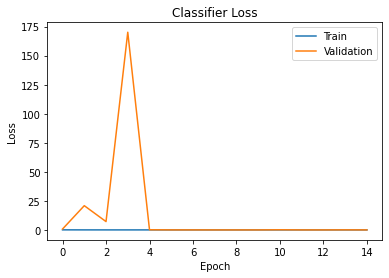

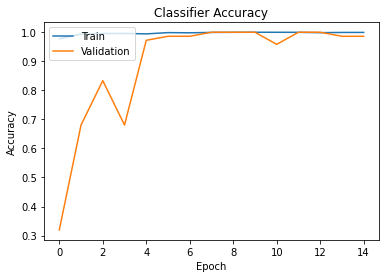

In [102]:
hist=history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [103]:
################# Ideal Theshold Calculation ############################

import numpy as np

def roc_curve(y_test, y_prob, thresholds):

    fpr = []
    tpr = []
    
    for threshold in thresholds:

        y_pred = np.where(y_prob >= threshold, 1, 0)

        fp = np.sum((y_pred == 1) & (y_test== 0))
        tp = np.sum((y_pred == 1) & (y_test == 1))

        fn = np.sum((y_pred == 0) & (y_test == 1))
        tn = np.sum((y_pred == 0) & (y_test == 0))

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))

    return [fpr, tpr]

y_prob1 = model.predict(X_test).ravel()
thresholds1= list(np.arange(-100, 100, 0.001))
[fpr1,tpr1]=roc_curve(y_test,y_prob1, thresholds1)
thresholds1=np.array(thresholds1)
tpr1=np.array(tpr1)
fpr1=np.array(fpr1)
import pandas as pd
i = np.arange(len(tpr1)) 
roc1 = pd.DataFrame({'tf' : pd.Series(tpr1-(1-fpr1), index=i), 'thresholds1' : pd.Series(thresholds1, index=i)})
ideal_roc_thresh1 = roc1.iloc[(roc1.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh1['thresholds1'])

Ideal threshold is:  100001    0.001
Name: thresholds1, dtype: float64


In [104]:
############## Confusion Matrix Calculation###################

series_list=ideal_roc_thresh1['thresholds1'].tolist()
mythreshold=series_list[0]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve

y_prob=model.predict(X_test)
y_pred = ((y_prob)>= mythreshold).astype(int)
y_pred1=y_pred
cm=confusion_matrix(y_test, y_pred)    #################### Confusion Matrix
print(cm)


[[55  0]
 [ 0 25]]


1.0


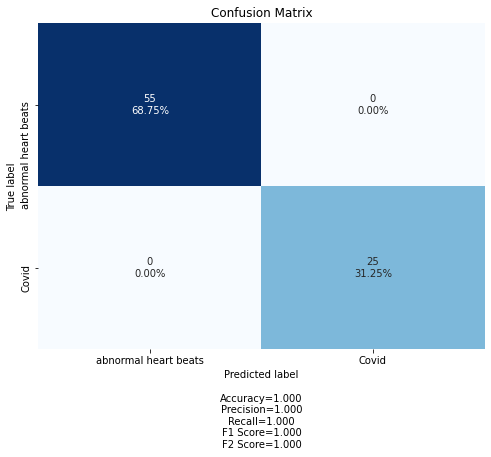

In [105]:
#################Confusion Metrics plot ###################################


from sklearn.metrics import confusion_matrix
from make_confusion_matrix import make_confusion_matrix
from calc_precision_recall import calc_precision_recall
TP,TN,FP,FN,precision, recall=calc_precision_recall(y_test, y_pred)

f2_score=(5*precision*recall) / ((4*precision) + recall)
print(f2_score)

cm=confusion_matrix(y_test,y_pred)
make_confusion_matrix(cm, figsize=(8,6), cbar=False,title="Confusion Matrix",categories=['abnormal heart beats',"Covid"])

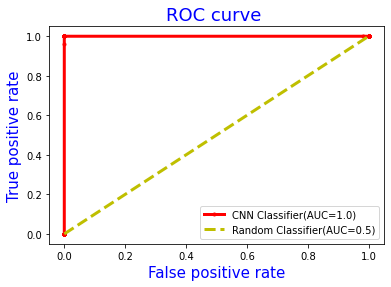

In [106]:
############################################### ROC Curve



plt.plot(fpr1, tpr1,linewidth=3, marker='.', color='Red')
plt.plot([0, 1], [0, 1], 'y--',linewidth=3)
plt.xlabel('False positive rate', fontsize=15, color='Blue')
plt.ylabel('True positive rate',fontsize=15,color='Blue')
plt.title('ROC curve ',fontsize=18,color='Blue')
plt.legend(['CNN Classifier(AUC=1.0)','Random Classifier(AUC=0.5)'],loc='lower right', fontsize=10)
plt.show()


In [107]:
###### Inference Time #############################
Number_of_samples=len(y_test)
import time
start_time=time.time()
y_preds = model.predict(X_test)
total_time=time.time()-start_time
print(total_time)
# Inference Time
Inference=total_time/Number_of_samples
print(Inference)
# Frames Per Second                    
FPS=1/Inference
print(["FPS=",FPS])

print("Inference Time = ", Inference)
print("FPS = ", FPS)

0.15453743934631348
0.0019317179918289184
['FPS=', 517.673906972941]
Inference Time =  0.0019317179918289184
FPS =  517.673906972941


In [108]:
y_pred = (model.predict(X_test)>= mythreshold).astype(int)
TP,TN,FP,FN,precision, recall = calc_precision_recall(y_test, y_pred)
Accuracy=((TP+TN)/(TP+TN+FP+FN))*100
Sensitivity=(TP/(TP+FN))*100
Specificity=(TN/(TN+FP))*100
Precision=(TP/(TP+FP))*100
Recall= Sensitivity
f2_score=((5*Precision*Recall) / ((4*Precision) + Recall))/100


##################### AUC ################

y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)



import pandas as pd
# assign values to lists.  
data = [{'Model':'Model1','Accuracy': Accuracy,'Precision':Precision, 'Sensitivity': Sensitivity, 'Specificity':Specificity,'F2-score':f2_score,'ROC-AUC':auc_value}]  
  
# Creates DataFrame.  
df = pd.DataFrame(data)  
df.index+=1
# Print the data  
print(df)
print("Ideal threshold =", mythreshold)

    Model  Accuracy  Precision  Sensitivity  Specificity  F2-score  ROC-AUC
1  Model1     100.0      100.0        100.0        100.0       1.0      1.0
Ideal threshold = 0.0010000004774894933


In [109]:
import tensorflow as tf
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', 
show_shapes=True)